In [1467]:
files[0]

'num researchers.csv'

In [1524]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, accuracy_score, precision_score, recall_score, classification_report, f1_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge, LassoCV, RidgeCV, ElasticNet
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.svm import SVC
import seaborn as sns
from functools import reduce
import numpy as np
import scipy as sp
import ml_insights as ml

<h1>Build Working Panel</h1>

In [1525]:
files=os.listdir("/home/sufyan/Metis/Week4/Project3/newdata/")
all_dfs=[]
for file in files:
    all_dfs.append(pd.read_csv("/home/sufyan/Metis/Week4/Project3/newdata/"+file))
for i in range(len(all_dfs)):
    all_dfs[i].set_index('Country or Area', inplace=True)
CountryCodes=pd.read_csv("country names and ID.csv")
#CountryCodes.set_index('name', inplace=True)

<h1>Cleaning dfs</h1>

In [1526]:
#df0
largedfs=[]
largedfs.append(all_dfs[0].loc[(all_dfs[0].Variant=='Instant replacement') & (all_dfs[0]['Year(s)']==2015)])
largedfs[0]=largedfs[0].merge(CountryCodes, left_index=True, right_on='name')
#other larger dfs
largelist=[3, 5, 7, 9, 10, 12, 15]
for i in largelist:
    largedfs.append(all_dfs[i].groupby('Country or Area').first().reset_index().merge(CountryCodes, left_on='Country or Area', right_on='name', how='outer'))

In [1527]:
#df1, df2 are two small
smalldfs=[]
for i in [1, 2, 4, 6, 8, 11, 13, 14]:
    smalldfs.append(all_dfs[i].groupby('Country or Area').first())#picks the most recent year's stat for each country

<h1>Merge Data into one DF</h1>

In [1528]:
largedfs[2].columns=['Country or Area','Value', 'id', 'name']
largedfs[5].columns=['Country or Area', 'Value', 'Whisker-high', 'Whisker-low',
       'Explained by: GDP per capita', 'Explained by: Social support',
       'Explained by: Healthy life expectancy',
       'Explained by: Freedom to make life choices',
       'Explained by: Generosity', 'Explained by: Perceptions of corruption',
       'Dystopia (1.85) + residual', 'id', 'name']
largedfs[7].columns=['Country or Area', 'Value', 'Count', 'Region', 'Subregion',
       'Year\nlisted', 'id', 'name']
templist=[]
for i in largedfs:
    templist.append(i[['id','Value']])
largelist=[0, 3, 5, 7, 9, 10, 12, 15]
for i in range(len(templist)):
    cols=list(templist[i].columns)
    cols[1]=files[largelist[i]].split('.')[0]
    templist[i].columns=cols
finaldf = reduce(lambda left,right: pd.merge(left,right,on='id'), templist)

#Adds Peace Index Rank
tempdf=pd.read_csv('PeaceIndex.csv')
tempdf=pd.merge(tempdf[['Country', '2017 score[23]', '2016 score[24]', '2015 score[25]']], CountryCodes, left_on='Country', right_on='name' )#, '2016 score[24]', '2015 score[25]'
tempdf.drop(['Country', 'name'], axis=1, inplace=True)
finaldf=pd.merge(finaldf, tempdf, on='id')

In [1529]:
finaldf.head()

,id,"Total population, both sexes combined (thousands)",Food (PIN),spendingeducationPofgdp,Internet users per 100 people,"Unemployment, general level (Thousands)",WorldHappiness,Percentage urban (thousands),murder,2017 score[23],2016 score[24],2015 score[25]
0,AFG,29502.073,2438261.0,3.1,8.260000,363.800,3.794,39.914,6.55,3.567,3.538,3.427
1,ALB,3234.927,817342.0,3.3,63.252933,149.794,4.644,60.482,2.28,1.908,1.867,1.821
2,DZA,39538.415,4174677.0,4.3,38.200000,1374.633,5.872,71.719,1.37,2.201,2.213,2.131
3,AGO,20549.386,1469816.0,3.5,12.400000,18.999,3.795,53.568,9.65,2.116,2.140,2.020
4,ARG,41996.689,33118920.0,5.8,69.400921,898.000,6.599,91.937,6.53,1.880,1.957,1.865


<h1>Adding old data</h1>

In [1530]:
filesOld=os.listdir("/home/sufyan/Metis/Week4/Project3/data/")
old_dfs=[]
olddflist=[]
for file in filesOld:
    old_dfs.append(pd.read_excel("/home/sufyan/Metis/Week4/Project3/data/"+file))
for i, df in enumerate(old_dfs):
    old_dfs[i]=pd.merge(old_dfs[i], CountryCodes, left_on=old_dfs[i].columns[0] , right_on='name')
for i, df in enumerate(old_dfs):
    tempdf=old_dfs[i].iloc[:,-3:-1]
    tempdf.columns=[filesOld[i].split('.')[0], 'id']
    olddflist.append(tempdf)
    
    olddfcomb=reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), olddflist)
olddfcomb.drop('Foreign investment inflow', axis=1, inplace=True)

In [1531]:
finaldf=pd.merge(finaldf, olddfcomb.dropna(), on='id', how='outer')
finaldf.columns

Index(['id', 'Total population, both sexes combined (thousands)', 'Food (PIN)',
       'spendingeducationPofgdp', 'Internet users per 100 people',
       'Unemployment, general level (Thousands)', 'WorldHappiness',
       'Percentage urban (thousands)', 'murder', '2017 score[23]',
       '2016 score[24]', '2015 score[25]', 'Years in school women 25 plus',
       'Indicator_BMI female ASM',
       'indicator_population density (per square km)',
       'Years in school women 15 to 44',
       'indicator_per capita government expenditure on health at average exchange rate (us$)',
       'Indicator_BMI male ASM',
       'Years in school, women 25 to 34 as percent of men',
       'indicator_government health spending of total gov spending (%)',
       'Indicator_HDI', 'GDPpercapitaconstant2000US',
       'indicator gapminder population', 'Years in school women 25-34'],
      dtype='object')

<h1>Added NewNewData</h1>

In [1532]:
files=os.listdir("/home/sufyan/Metis/Week4/Project3/NewNewData/")

newlistdfs=[]
for file in files:
    newlistdfs.append(pd.read_csv("/home/sufyan/Metis/Week4/Project3/NewNewData/"+file))
# for i in range(len(all_dfs)):
#     newlistdfs[i].set_index('Country or Area', inplace=True)
# CountryCodes=pd.read_csv("country names and ID.csv")
#CountryCodes.set_index('name', inplace=True)
newlistdfs[0]=pd.merge(newlistdfs[0][['LOCATION','TIME','Value']].groupby('LOCATION').last(), CountryCodes, left_index=True, right_on='id', how='outer')
newlistdfs[0].drop(['name', 'TIME'], axis=1, inplace=True)
templist=list(newlistdfs[0].columns)
templist[0]=files[0].split('.')[0]
newlistdfs[0].columns=templist

newlistdfs[1]=pd.merge(newlistdfs[1][['Indicator','LOCATION','TIME','Value']].loc[newlistdfs[1]['Indicator']=='Graduates from ISCED 5 programmes in tertiary education, both sexes (number)'].groupby('LOCATION').last().fillna(-1), CountryCodes, left_index=True, right_on='id')
newlistdfs[1].drop(['name', 'TIME'], axis=1, inplace=True)
templist=list(newlistdfs[1].columns)
templist[1]=files[1].split('.')[0]
newlistdfs[1].columns=templist

newlistdfs[2]=pd.merge(newlistdfs[2][['Jurisdiction','2015']], CountryCodes, left_on='Jurisdiction',right_on='name')
newlistdfs[2].drop(['Jurisdiction', 'name'], axis=1, inplace=True)
newlistdfs[2].replace('-',np.nan,inplace=True)
newlistdfs[2]['2015']=newlistdfs[2]['2015'].astype(float)
templist=list(newlistdfs[2].columns)
templist[0]=files[2].split('.')[0]
newlistdfs[2].columns=templist

newlistdfs[3]=pd.merge(newlistdfs[3][['Indicator','LOCATION','TIME','Value']].loc[newlistdfs[3]['Indicator']=='Total number of indoor cinemas'].groupby('LOCATION').last().fillna(-1), CountryCodes, left_index=True, right_on='id')
newlistdfs[3].drop(['name', 'TIME'], axis=1, inplace=True)
templist=list(newlistdfs[3].columns)
templist[1]=files[3].split('.')[0]
newlistdfs[3].columns=templist


newnewdfcomb=reduce(lambda left, right: pd.merge(left, right, on='id', how='outer'), newlistdfs)
newnewdfcomb.drop(['Indicator_x','Indicator_y'], inplace=True, axis=1)
finaldf=pd.merge(finaldf, newnewdfcomb, on='id')

In [1533]:
for col in list(finaldf.columns):
    try: finaldf[col].fillna(np.mean(finaldf[col].dropna()), inplace=True)
    except:pass
TYPE='mean'

In [1534]:
#finaldf['Food (PIN)'].fillna(np.mean(finaldf['Food (PIN)']), inplace=True)
tester='spendingeducationPofgdp'
print(sp.stats.mode(finaldf[tester]))
print(np.median(finaldf[tester].dropna()))
# np.mean(newlistdfs[2].replace('-', np.nan).dropna().iloc[:,0].astype(float))

ModeResult(mode=array([ 4.67357143]), count=array([16]))
4.67357142857


In [1535]:
finaldf.dropna()

,id,"Total population, both sexes combined (thousands)",Food (PIN),spendingeducationPofgdp,Internet users per 100 people,"Unemployment, general level (Thousands)",WorldHappiness,Percentage urban (thousands),murder,2017 score[23],...,"Years in school, women 25 to 34 as percent of men",indicator_government health spending of total gov spending (%),Indicator_HDI,GDPpercapitaconstant2000US,indicator gapminder population,Years in school women 25-34,num researchers,numtertgrads,Corruption,num cinemas
0,AFG,2.950207e+04,2.438261e+06,3.100000,8.260000,363.800000,3.794000,39.914000,6.550000,3.567000,...,93.701045,11.480068,0.660277,7672.925428,5.108608e+07,9.186923,1105.731598,-1.000000e+00,11.000000,281.663158
1,ALB,3.234927e+03,8.173420e+05,3.300000,63.252933,149.794000,4.644000,60.482000,2.280000,1.908000,...,101.851852,8.422928,0.739000,1965.707230,2.896679e+06,11.000000,2.638630,2.970000e+02,36.000000,7.000000
2,DZA,3.953842e+04,4.174677e+06,4.300000,38.200000,1374.633000,5.872000,71.719000,1.370000,2.201000,...,98.571429,8.117118,0.698000,2255.225482,3.966652e+07,6.900000,1.989480,1.336300e+04,36.000000,281.663158
3,AGO,2.054939e+04,1.469816e+06,3.500000,12.400000,18.999000,3.795000,53.568000,9.650000,2.116000,...,75.000000,7.185224,0.486000,629.955306,2.502197e+07,4.500000,0.281840,-1.000000e+00,15.000000,281.663158
4,ARG,4.199669e+04,3.311892e+07,5.800000,69.400921,898.000000,6.599000,91.937000,6.530000,1.880000,...,111.214953,14.653654,0.797000,11601.630223,4.341676e+07,11.900000,6.019010,1.274230e+05,32.000000,299.000000
5,ARM,3.041776e+03,8.444350e+05,3.100000,58.249332,74.700000,4.376000,75.071000,2.450000,2.220000,...,106.250000,6.421649,0.716000,1384.085162,3.017712e+06,11.900000,3.897830,7.736000e+03,35.000000,281.663158
6,AUS,2.408089e+04,1.171003e+07,5.100000,84.560519,100.124000,7.284000,95.896000,0.980000,1.425000,...,103.305785,16.838716,0.929000,25306.824938,2.396897e+07,12.500000,12.680000,1.181730e+05,79.000000,492.000000
7,AUT,8.723641e+03,3.638986e+06,6.000000,83.926300,162.300000,7.006000,76.378000,0.510000,1.265000,...,100.840336,16.191784,0.885000,27266.403350,8.544586e+06,12.000000,27.892850,2.716468e+04,76.000000,138.000000
8,AZE,9.749230e+03,1.740050e+06,2.800000,77.000000,261.400000,5.234000,61.506000,2.450000,2.426000,...,101.680672,4.215536,0.731000,2338.896558,9.753968e+06,12.100000,53.306200,1.476800e+04,29.000000,10.000000
9,BGD,1.602495e+05,1.441598e+07,2.200000,14.400000,2104.000000,4.608000,44.271000,2.510000,2.035000,...,78.571429,7.919265,0.500000,588.369178,1.609956e+08,4.400000,0.325650,2.961400e+04,25.000000,281.663158


<h1>Binning</h1>

In [1480]:
peaceyear='2017 score[23]'
# finaldf['peace']=pd.qcut(finaldf[peaceyear], 3, labels=['0','1','2'])
finaldf['peace']=pd.qcut(finaldf[peaceyear], 7, labels=['0','1','2','3','4','5','6'])
finaldf=finaldf.loc[finaldf['peace'].astype(float)%2==0]
# finaldf['oldcat']=pd.qcut(finaldf['2016 score[24]'], 5, labels=['0','1','2','3','4'])
#finaldf.drop(peaceyear, axis=1, inplace=True)

myl=list(finaldf.columns)
myl.remove('peace')
myl.remove('id')
myl.remove('murder')
myl.remove('2017 score[23]')
myl.remove('2016 score[24]')
myl.remove('2015 score[25]')

finaldf[myl][0:100].columns

Index(['Total population, both sexes combined (thousands)', 'Food (PIN)',
       'spendingeducationPofgdp', 'Internet users per 100 people',
       'Unemployment, general level (Thousands)', 'WorldHappiness',
       'Percentage urban (thousands)', 'Years in school women 25 plus',
       'Indicator_BMI female ASM',
       'indicator_population density (per square km)',
       'Years in school women 15 to 44',
       'indicator_per capita government expenditure on health at average exchange rate (us$)',
       'Indicator_BMI male ASM',
       'Years in school, women 25 to 34 as percent of men',
       'indicator_government health spending of total gov spending (%)',
       'Indicator_HDI', 'GDPpercapitaconstant2000US',
       'indicator gapminder population', 'Years in school women 25-34',
       'num researchers', 'numtertgrads', 'Corruption', 'num cinemas'],
      dtype='object')

<h1>export tsv</h1>

In [1481]:
# finaldf.set_index('id')['peace'].to_json('webappdata.json')

<h1>Modeling</h1>

In [1510]:
import warnings; warnings.simplefilter('ignore')
X_train, X_test, y_train, y_test = train_test_split(finaldf[myl], finaldf['peace'], test_size=.3)
model=KNeighborsClassifier(n_jobs=-1, n_neighbors=13)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)

scores=cross_val_score(model, X_train, y_train, cv=4, n_jobs=-1)
print(scores)
print('test error: {}'.format(np.mean(scores)))
print('train error: {}'.format(model.score(X_train, y_train)))
print('test f1 score: {}'.format(f1_score(y_test, y_pred, average=None)))

[ 0.35294118  0.58823529  0.53333333  0.5       ]
test error: 0.4936274509803922
train error: 0.47619047619047616
test f1 score: [ 0.42105263  0.          0.          0.55555556]


In [1483]:
model=LogisticRegression(n_jobs=-1)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)

scores=cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print(scores, np.mean(scores))
print('test accuracy: {}'.format(model.score(X_test, y_test)))
print('train accuracy: {}'.format(model.score(X_train, y_train)))
print('test f1 score: {}'.format(f1_score(y_test, y_pred, average=None)))

[ 0.35714286  0.5         0.69230769  0.41666667  0.4       ] 0.473223443223
test accuracy: 0.2962962962962963
train accuracy: 0.5873015873015873
test f1 score: [ 0.28571429  0.11111111  0.5         0.42857143]


In [1484]:
model=SVC()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
scores=cross_val_score(model, X_test, y_test, cv=5, n_jobs=-1)
print(scores)
print('test error: {}'.format(np.mean(scores)))
print('train error: {}'.format(model.score(X_train, y_train)))
print('test f1 score: {}'.format(f1_score(y_test, y_pred, average=None)))

[ 0.28571429  0.33333333  0.33333333  0.4         0.33333333]
test error: 0.33714285714285713
train error: 1.0
test f1 score: [ 0.          0.          0.25806452  0.        ]


In [1485]:
X_train, X_test, y_train, y_test = train_test_split(finaldf[myl], finaldf['peace'], test_size=.3)
model=GaussianNB()
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
scores=cross_val_score(model, X_test, y_test, cv=5, n_jobs=-1)
print(scores)
print('test accuracy: {}'.format(np.mean(scores)))
print('train error: {}'.format(model.score(X_train, y_train)))
print('test f1 score: {}'.format(f1_score(y_test, y_pred, average=None)))

[ 0.          0.33333333  0.5         0.6         0.5       ]
test accuracy: 0.3866666666666666
train error: 0.49206349206349204
test f1 score: [ 0.44444444  0.          0.          0.22222222]


<h1>Random Forest</h1>

[ 0.28571429  0.28571429  0.23076923  0.25        0.3       ]
cv accuracy: 0.27043956043956047
train accuracy: 0.49206349206349204
test accuracy: 0.5925925925925926


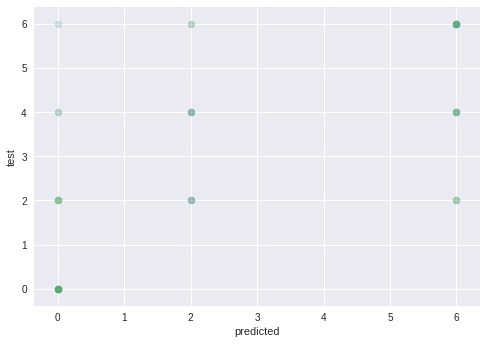

In [1486]:
# model=GradientBoostingClassifier(n_estimators=1000, max_depth=2, min_samples_leaf=2)#overfits aloooooot
model=RandomForestClassifier(n_estimators=1000, max_depth=2, min_samples_leaf=20, n_jobs=-1)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
scores=cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print(scores)
print('cv accuracy: {}'.format(np.mean(scores)))
print('train accuracy: {}'.format(model.score(X_train, y_train)))
print('test accuracy: {}'.format(model.score(X_test,y_test)))
plt.scatter(y_pred, y_test, alpha=.1)
plt.scatter(model.predict(X_train), y_train, alpha=.1)
plt.ylabel('test')
plt.xlabel('predicted')
plt.show()
#fillna -1
# [ 0.9         0.85        0.73684211  0.94736842  0.78947368]
# cv accuracy: 0.8447368421052632
# train accuracy: 0.9896907216494846
# test accuracy: 0.9047619047619048

#fillna mean
#cv: .81, test: .85

#fillna mode
# [ 0.75        0.7         0.85        0.78947368  0.94444444]
# cv accuracy: 0.8067836257309942
# train accuracy: 0.979381443298969
# test accuracy: 0.9285714285714286

#fillna median
# [ 0.9         0.7         0.8         0.94736842  0.88888889]
# cv accuracy: 0.8472514619883041
# train accuracy: 0.979381443298969
# test accuracy: 0.8095238095238095

# [ 0.54166667  0.56521739  0.36363636  0.4         0.5       ]
# cv accuracy: 0.47410408432147555
# train accuracy: 0.7798165137614679
# test accuracy: 0.6382978723404256

In [1487]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      1.00      0.83         5
          2       0.44      0.80      0.57         5
          4       0.00      0.00      0.00         8
          6       0.64      0.78      0.70         9

avg / total       0.43      0.59      0.49        27



In [1488]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.71      1.00      0.83         5
          2       0.44      0.80      0.57         5
          4       0.00      0.00      0.00         8
          6       0.64      0.78      0.70         9

avg / total       0.43      0.59      0.49        27



In [1489]:
# param_grid = { 
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'max_depth' : [2,3,4,5,6]
# #     'min_samples_split' : [2,3,4,5,6],
# #     'min_samples_leaf' : [1,2,3,4,5,6]
# }

# CV_rfc = GridSearchCV(estimator=model, param_grid=param_grid, cv= 5)
# CV_rfc.fit(X_test, y_test)
# print(CV_rfc.best_params_)
# #{'max_depth': 2, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2}

In [1490]:
# proba = cross_val_predict(model, X_test[:7], y_test[:7], method='predict_proba')
# proba

In [1491]:
# CountryCodes.set_index('id').loc[list(finaldf.iloc[list(X_test[:7].index)].id)]

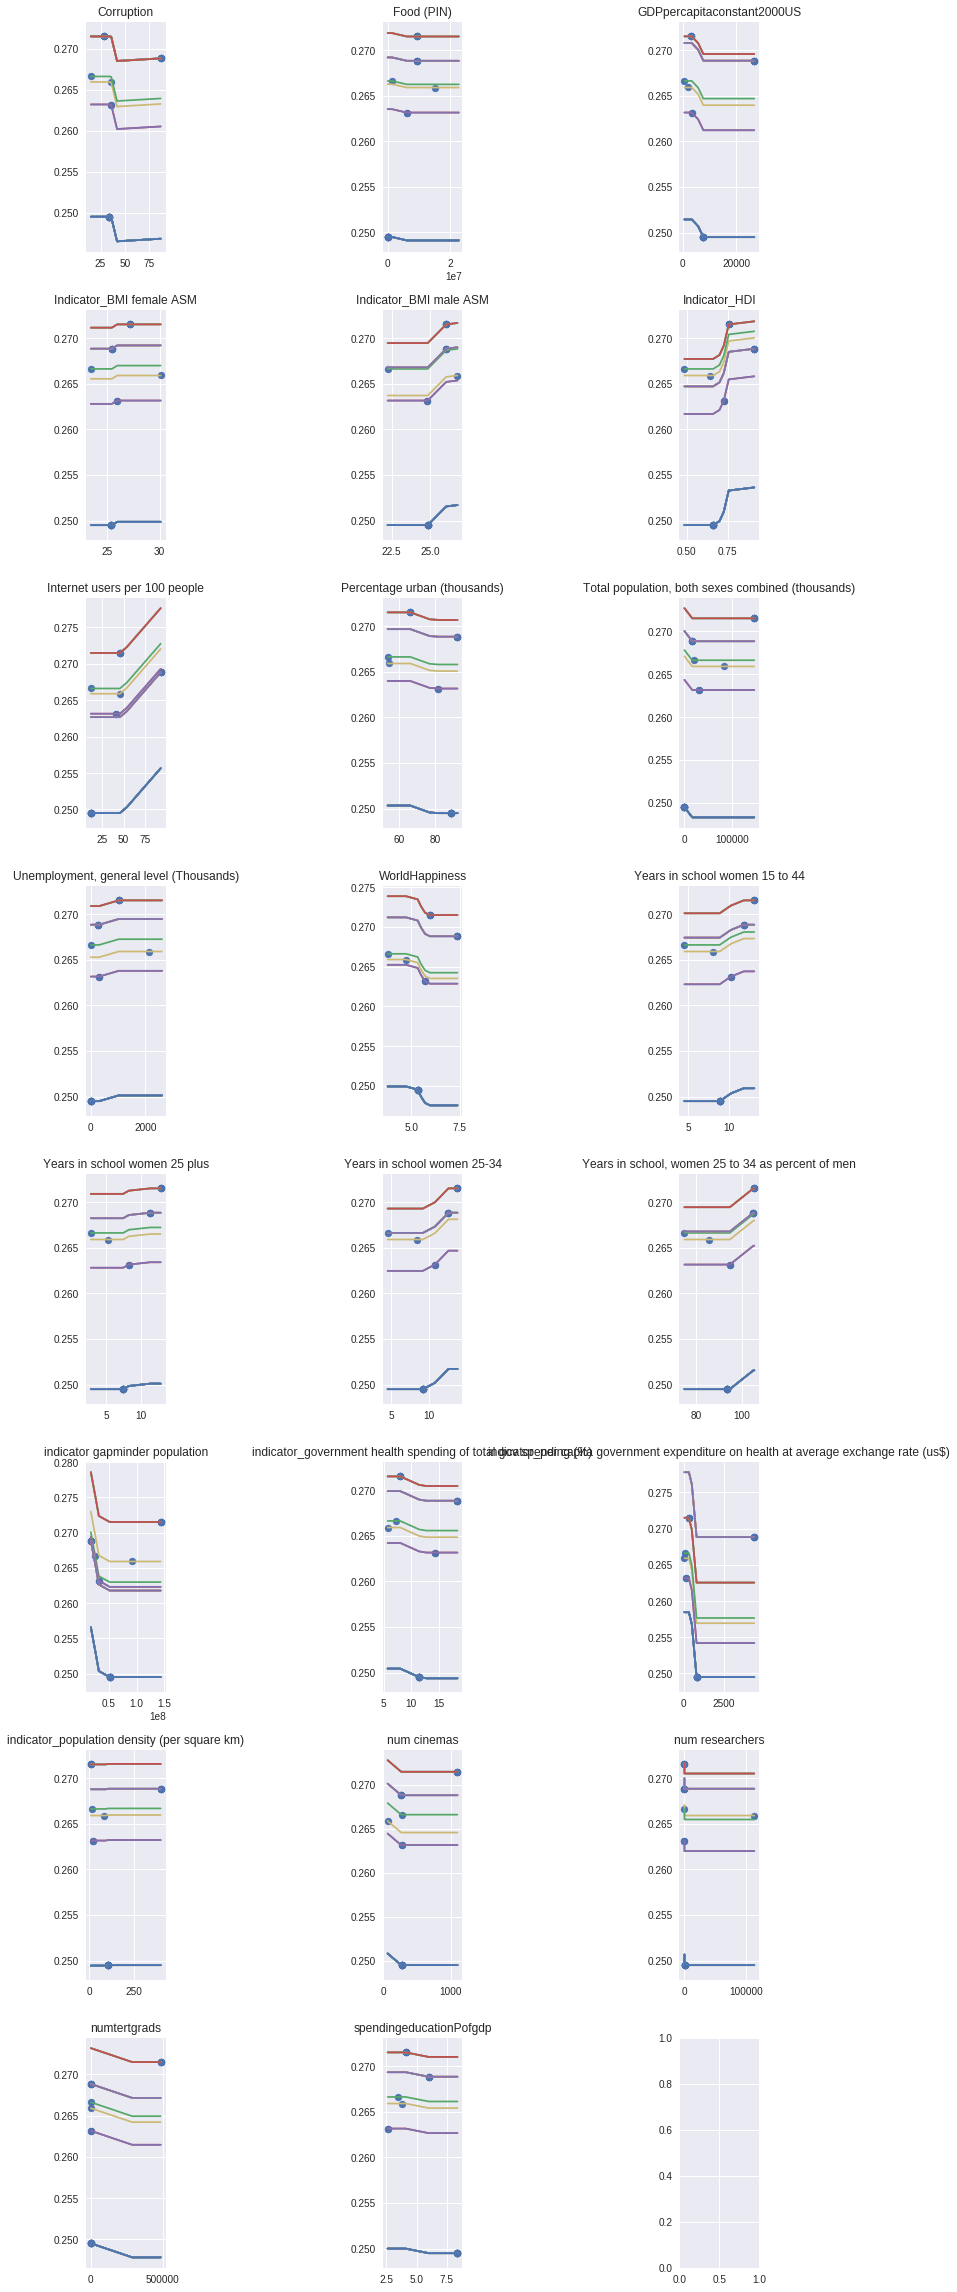

In [1492]:
mxr=ml.ModelXRay(model, X_test[:7])
mxr.feature_dependence_plots(num_pts=21)
# plt.savefig('FeatureDependencePlots[withpreviousyeardata].png'.format(TYPE),dpi=150)
plt.show()

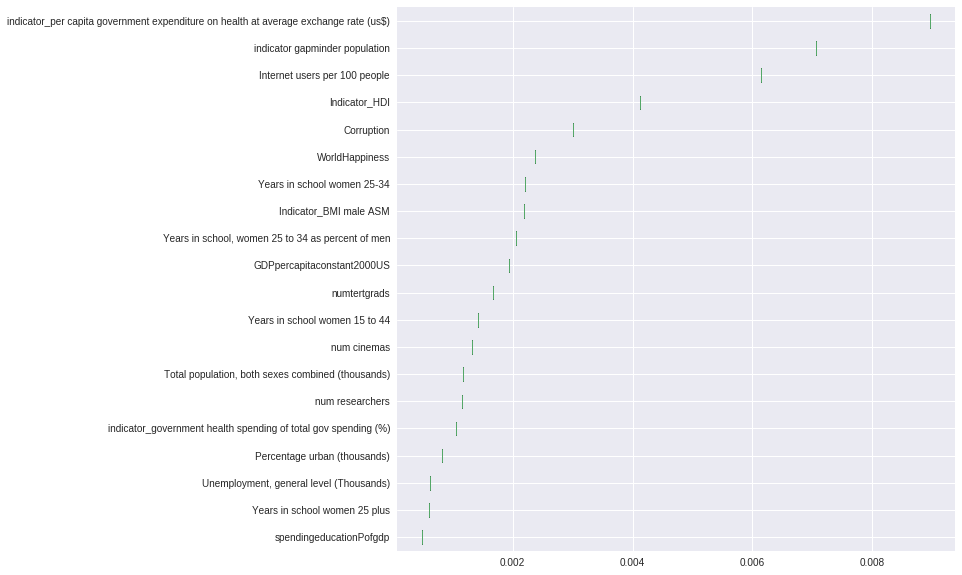

In [1493]:
mxr.feature_effect_summary()
# plt.savefig('FeatureEffectSummary[cut]'.format(TYPE), dpi=150)
plt.show()

[ 0.44886915  0.71570362  0.61882337  0.29258602  0.2730229 ]
cv accuracy: 0.4698010103254832
train accuracy: 0.837837492957666
test accuracy: 0.27421717066686313


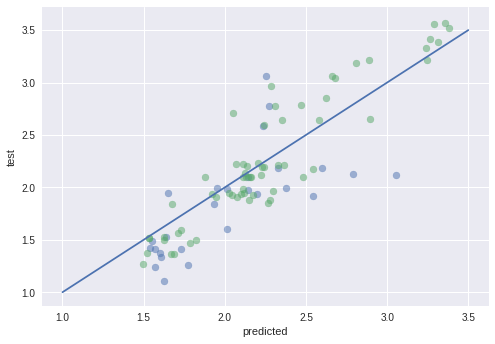

In [1494]:
X_train, X_test, y_train, y_test = train_test_split(finaldf[myl], finaldf[peaceyear], test_size=.3)
model=RandomForestRegressor(n_estimators=1000, n_jobs=-1, max_depth=3, min_samples_leaf=2)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
scores=cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print(scores)
print('cv accuracy: {}'.format(np.mean(scores)))
print('train accuracy: {}'.format(model.score(X_train, y_train)))
print('test accuracy: {}'.format(r2_score(y_test, y_pred)))
plt.scatter(y_pred, y_test, alpha=.5)
plt.scatter(model.predict(X_train), y_train, alpha=.5)
plt.ylabel('test')
plt.xlabel('predicted')
plt.plot([1,3.5],[1,3.5])
plt.show()

In [1495]:
# [ 0.95959665  0.93562541  0.97569974  0.99085886  0.95881319]
# cv accuracy: 0.9641187668398136
# train accuracy: 0.9837572047443451
# test accuracy: 0.9467134289979209

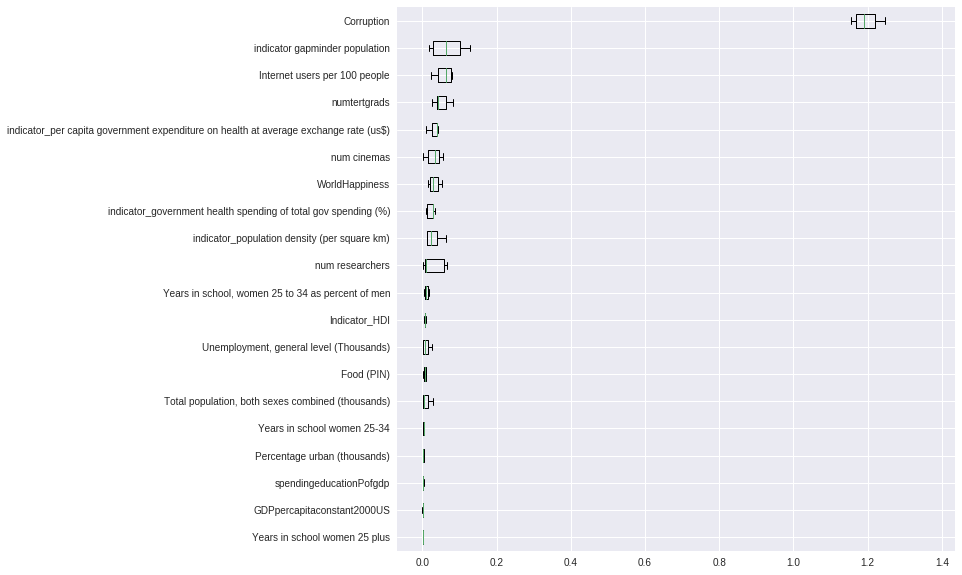

In [1496]:
mxr=ml.ModelXRay(model, X_test[:7])
# mxr.feature_dependence_plots(num_pts=21)
# plt.show()
mxr.feature_effect_summary()
plt.show()

In [1497]:
model=Lasso(alpha=250.0)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)
y_train_pred=model.predict(X_train)
scores=cross_val_score(model, X_train, y_train, cv=5, n_jobs=-1)
print(scores)
print('cv accuracy: {}'.format(np.mean(scores)))
print('train accuracy: {}'.format(model.score(X_train, y_train)))
print('test accuracy: {}'.format(r2_score(y_test, y_pred)))

[ -4.81909054e-01   5.20702263e-02   2.82558450e-01   4.07359719e-06
  -8.04077686e-01]
cv accuracy: -0.19027079805151448
train accuracy: 0.1990921852708334
test accuracy: -0.13316981204641198


In [1498]:
list(zip(myl, model.coef_!=0))

[('Total population, both sexes combined (thousands)', True),
 ('Food (PIN)', True),
 ('spendingeducationPofgdp', False),
 ('Internet users per 100 people', False),
 ('Unemployment, general level (Thousands)', False),
 ('WorldHappiness', False),
 ('Percentage urban (thousands)', False),
 ('Years in school women 25 plus', False),
 ('Indicator_BMI female ASM', False),
 ('indicator_population density (per square km)', False),
 ('Years in school women 15 to 44', False),
 ('indicator_per capita government expenditure on health at average exchange rate (us$)',
  False),
 ('Indicator_BMI male ASM', False),
 ('Years in school, women 25 to 34 as percent of men', False),
 ('indicator_government health spending of total gov spending (%)', False),
 ('Indicator_HDI', False),
 ('GDPpercapitaconstant2000US', True),
 ('indicator gapminder population', True),
 ('Years in school women 25-34', False),
 ('num researchers', False),
 ('numtertgrads', True),
 ('Corruption', False),
 ('num cinemas', False)]

In [1546]:
finaldf.loc[(finaldf.id=='BWA') | (finaldf.id=='ZAF')][['id','indicator gapminder population','Corruption','Indicator_HDI','indicator_government health spending of total gov spending (%)','indicator_per capita government expenditure on health at average exchange rate (us$)']]



,id,indicator gapminder population,Corruption,Indicator_HDI,indicator_government health spending of total gov spending (%),indicator_per capita government expenditure on health at average exchange rate (us$)
16,BWA,2262485.0,63.0,0.633,16.992652,445.760723
123,ZAF,54490406.0,44.0,0.619,11.872046,286.100065


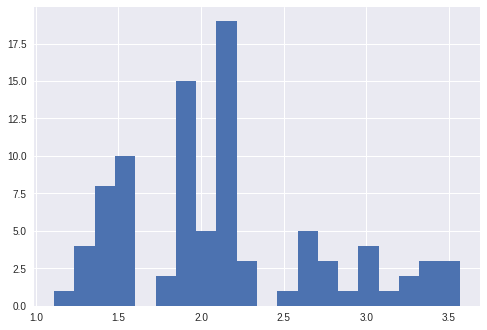

In [1501]:
plt.hist(finaldf[peaceyear], bins=20)
plt.show()

In [1511]:
finaldf

,id,"Total population, both sexes combined (thousands)",Food (PIN),spendingeducationPofgdp,Internet users per 100 people,"Unemployment, general level (Thousands)",WorldHappiness,Percentage urban (thousands),murder,2017 score[23],...,indicator_government health spending of total gov spending (%),Indicator_HDI,GDPpercapitaconstant2000US,indicator gapminder population,Years in school women 25-34,num researchers,numtertgrads,Corruption,num cinemas,peace
0,AFG,29502.073000,2.438261e+06,3.100000,8.260000,363.800000,3.794000,39.914000,6.550000,3.567000,...,11.480068,0.660277,7672.925428,5.108608e+07,9.186923,1105.731598,-1.000000e+00,11.000000,281.663158,6
1,ALB,3234.927000,8.173420e+05,3.300000,63.252933,149.794000,4.644000,60.482000,2.280000,1.908000,...,8.422928,0.739000,1965.707230,2.896679e+06,11.000000,2.638630,2.970000e+02,36.000000,7.000000,2
2,DZA,39538.415000,4.174677e+06,4.300000,38.200000,1374.633000,5.872000,71.719000,1.370000,2.201000,...,8.117118,0.698000,2255.225482,3.966652e+07,6.900000,1.989480,1.336300e+04,36.000000,281.663158,4
3,AGO,20549.386000,1.469816e+06,3.500000,12.400000,18.999000,3.795000,53.568000,9.650000,2.116000,...,7.185224,0.486000,629.955306,2.502197e+07,4.500000,0.281840,-1.000000e+00,15.000000,281.663158,4
4,ARG,41996.689000,3.311892e+07,5.800000,69.400921,898.000000,6.599000,91.937000,6.530000,1.880000,...,14.653654,0.797000,11601.630223,4.341676e+07,11.900000,6.019010,1.274230e+05,32.000000,299.000000,2
5,ARM,3041.776000,8.444350e+05,3.100000,58.249332,74.700000,4.376000,75.071000,2.450000,2.220000,...,6.421649,0.716000,1384.085162,3.017712e+06,11.900000,3.897830,7.736000e+03,35.000000,281.663158,4
6,AUS,24080.887000,1.171003e+07,5.100000,84.560519,100.124000,7.284000,95.896000,0.980000,1.425000,...,16.838716,0.929000,25306.824938,2.396897e+07,12.500000,12.680000,1.181730e+05,79.000000,492.000000,0
7,AUT,8723.641000,3.638986e+06,6.000000,83.926300,162.300000,7.006000,76.378000,0.510000,1.265000,...,16.191784,0.885000,27266.403350,8.544586e+06,12.000000,27.892850,2.716468e+04,76.000000,138.000000,0
10,BLR,9468.212000,5.806134e+06,5.200000,62.230361,37.300000,5.569000,77.493000,3.580000,2.141000,...,9.945442,0.756000,2890.345675,9.495826e+06,13.000000,5.429130,4.141500e+04,32.000000,129.000000,4
11,BEL,11259.648000,2.777542e+06,6.600000,85.052900,333.659000,6.891000,98.384000,1.950000,1.525000,...,15.118588,0.886000,24733.626956,1.129919e+07,13.400000,22.075180,2.601000e+03,77.000000,88.000000,0
